### 선분 검출

어떤 응용에서는 이전에 구현한 에지 맵을 사용하면 되는 경우가 있지만, 이웃한 에지 화소를 연결해 에지 토막(edge segment)으로 만들어 응용하는 경우가 대부분이다. 게다가 에지 토막을 직선으로 근사화하여 선분(직선 토막(line segment))으로 변환해야 하는 응용도 많다.

### 에지 연결과 선분 근사

#### 세션화
세션화 과정에서는 기존 에지맵의 에지의 두께를 1로 바꿔준다.  
여기서는 비교적 간단하고 성능이 좋은 SPTA(Safe Point Thinning Algorithms)를 설명한다.
SPTA알고리즘은 아래 그림의 3x3 마스크를 현재 조사하고 있는 에지 화소 p에 씌운다.

![](./data/spta.jpg)

마스크의 0은 비에지, 1은 에지를 뜻하고 x는 0과 1 어느 것이라도 좋다는 기호이다. 이 네 개의 마스크는 하나의 그룹을 형성하는데, 위 그림은 화소 p의 이웃 n_4가 0인 그룹이다.  
더 효율적으로 계산하기 위해 네 개의 마스크 대신 논리식 s4를 검사해도 같은 결과를 얻는다. '는 부정, +는 or, dot은 and이다.

이 과정을 한번 적용하면 바깥쪽에서 한 화소 두께를 벗기는 셈이 되는데, 원래 SPTA는 더 이상 변화가 없을 때까지 반복하지만 보통 두께는 2~3이므로 두 번만 적용해도 충분하다.

### 코드구현
이전에 작성된 코드는 util에 저장하였다.[링크](https://github.com/Songminkee/computer_vision/blob/master/util.py).

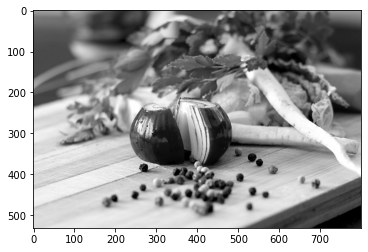

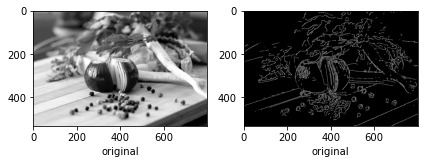

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from util import *


img = cv2.imread('./data/food.jpg',cv2.IMREAD_GRAYSCALE)

plt.imshow(img,cmap='gray')
plt.show()

gau_img = gaussian_blur(img,1)
canny_img = canny(gau_img,30,75)


fig = plt.figure()
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.xlabel('original')

plt.subplot(122)
plt.imshow(canny_img,cmap='gray')
plt.xlabel('original')
fig.tight_layout()
plt.show()

spta는 위의 식을 참고하여 작성했다.

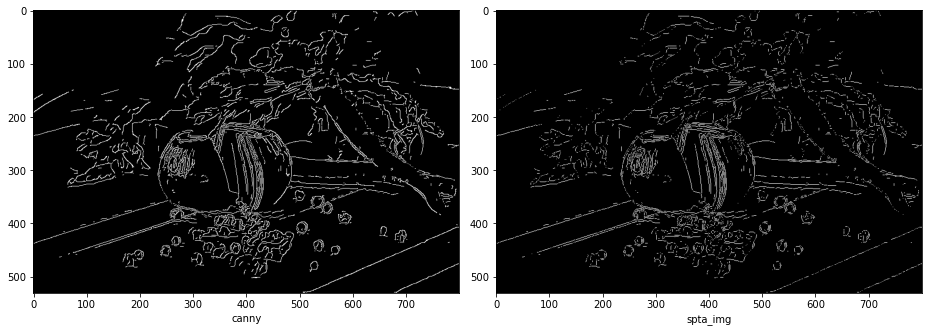

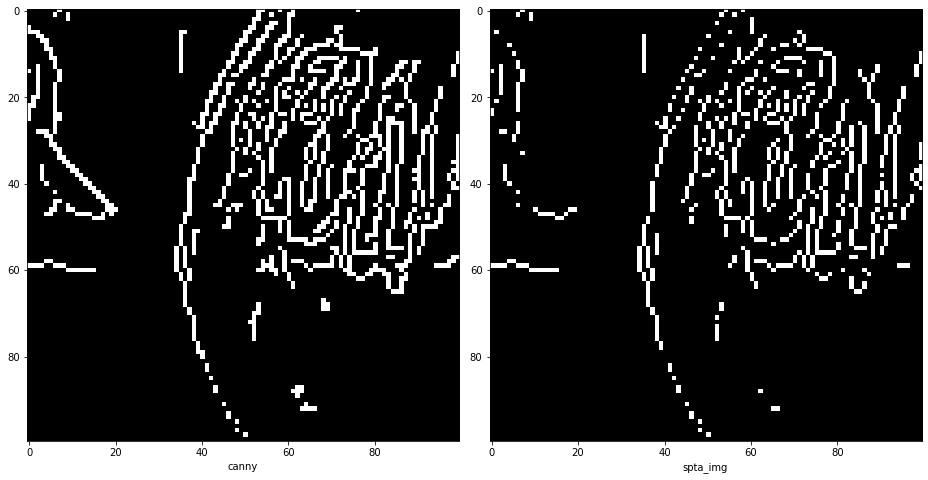

In [2]:
def SPTA(img):
    '''
    n5 n6 n7
    n4 p  n0
    n3 n2 n1
    :param img:
    :return:
    '''
    img = img>0
    n4 = np.pad(img[:, :-1], ((0, 0), (1, 0)))
    n0 = np.pad(img[:, 1:], ((0, 0), (0, 1)))
    n6 = np.pad(img[:-1, :], ((1, 0), (0, 0)))
    n2 = np.pad(img[1:, :], ((0, 1), (0, 0)))
    n1 = np.pad(n2[:, 1:], ((0, 0), (0, 1)))
    n7 = np.pad(n6[:, 1:], ((0, 0), (0, 1)))
    n3 = np.pad(n2[:, :-1], ((0, 0), (1, 0)))
    n5 = np.pad(n6[:, :-1], ((0, 0), (1, 0)))
    n0_logic = np.logical_not(n0) & (n4 & (n5 + n6 + n2 + n3) & (n6 + np.logical_not(n7)) & (n2 + np.logical_not(n1)))
    n4_logic = np.logical_not(n4) & (n0 & (n1 + n2 + n6 + n7) & (n2 + np.logical_not(n3)) & (n6 + np.logical_not(n5)))
    n2_logic = np.logical_not(n2) & (n6 & (n7 + n0 + n4 + n5) & (n0 + np.logical_not(n1)) & (n4 + np.logical_not(n3)))
    n6_logic = np.logical_not(n6) & (n2 & (n3 + n4 + n0 + n1) & (n4 + np.logical_not(n5)) & (n0 + np.logical_not(n7)))
    logical = n0_logic+n4_logic+n2_logic+n6_logic

    return np.uint8(np.where(logical,False,img))*255

spta_img = SPTA(canny_img)

fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(canny_img,cmap='gray')
plt.xlabel('canny')

plt.subplot(122)
plt.imshow(spta_img,cmap='gray')
plt.xlabel('spta_img')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(canny_img[250:350,200:300],cmap='gray')
plt.xlabel('canny')

plt.subplot(122)
plt.imshow(spta_img[250:350,200:300],cmap='gray')
plt.xlabel('spta_img')
fig.tight_layout()
plt.show()

spta를 적용한 이후 에지의 두께가 얇아진 것을 확인할 수 있다.

### 에지추적
에지 추적은 에지를 연결하는 방법에 대한 것이다.  
먼저 끝점과 분기점을 수집하여 추적 시작점으로 사용한다.
분기점은 다음과 같이 시계 방향으로 에지에서 비에지로 변하는 횟수이다.



In [3]:
import queue

def front_pixel(y,x,dir):
    if dir%2==0:
        front=np.zeros((3,3),np.int32)
    else:
        front = np.zeros((5,3),np.int32)

    if dir==0:
        front[0]=[y-1,x+1,7]
        front[1]=[y,x+1,0]
        front[2] =[y+1,x+1,1]
    elif dir==1:
        front[0]=[y-1,x+1,7]
        front[1] =[y,x+1,0]
        front[2] = [y + 1, x + 1, 1]
        front[3] = [y + 1, x, 2]
        front[4] = [y + 1, x-1, 3]
    elif dir==2:
        front[0] = [y + 1, x + 1, 1]
        front[1] = [y + 1, x, 2]
        front[2] = [y + 1, x-1, 3]
    elif dir==3:
        front[0] = [y + 1, x + 1, 1]
        front[1] = [y + 1, x, 2]
        front[2] = [y + 1, x - 1, 3]
        front[3] = [y,x-1,4]
        front[4] = [y-1,x-1,5]
    elif dir==4:
        front[0] = [y + 1, x - 1, 3]
        front[1] = [y, x - 1, 4]
        front[2] = [y - 1, x - 1, 5]
    elif dir==5:
        front[0] = [y + 1, x - 1, 3]
        front[1] = [y, x - 1, 4]
        front[2] = [y - 1, x - 1, 5]
        front[3] = [y-1,x,6]
        front[4] = [y-1,x+1,7]
    elif dir == 6:
        front[0] = [y - 1, x - 1, 5]
        front[1] = [y - 1, x, 6]
        front[2] = [y - 1, x + 1, 7]
    elif dir == 7:
        front[0] = [y - 1, x - 1, 5]
        front[1] = [y - 1, x, 6]
        front[2] = [y - 1, x + 1, 7]
        front[3]=[y,x+1,0]
        front[4] =[y+1,x+1,1]
    return front

In [4]:
def edge_segment_detection(spta_img):
    dx = np.array([0, 1, 1, 1, 0, -1, -1, -1])
    dy = np.array([1, 1, 0, -1, -1, -1, 0, 1])
    spta_img[0, :] = spta_img[:, 0] = spta_img[-1, :] = spta_img[:, -1] = 0
    spta_img //=255
    c = np.zeros_like(spta_img)
    for i in range(1, len(spta_img) - 1):
        for j in range(1, len(spta_img[0]) - 1):
            flag = False
            count = 0
            for z in range(9):
                idx = z
                if z == 8:
                    idx = 0
                y = i + dy[idx]
                x = j + dx[idx]
                if flag and spta_img[y, x] == 0:
                    count += 1
                    flag=False
                elif spta_img[y, x]:
                    flag = True
                else:
                    flag=False

            c[i, j] = count

    zeros = np.zeros([spta_img.shape[0], spta_img.shape[1], 3], np.uint8)

    # start and branch
    zeros[..., 0] = spta_img * 255
    zeros[..., 1] = spta_img * 255
    zeros[..., 2] = spta_img * 255

    zeros[..., 1] = np.where(c == 1, 0, zeros[..., 1])
    zeros[..., 2] = np.where(c == 1, 0, zeros[..., 2])
    zeros[..., 0] = np.where(c >= 3, 0, zeros[..., 0])
    zeros[..., 1] = np.where(c >= 3, 0, zeros[..., 1])
    plt.imshow(zeros)
    plt.xlabel("start")
    plt.show()

    Q = queue.Queue()
    for i in range(1, len(spta_img) - 1):
        for j in range(1, len(spta_img[0]) - 1):
            if c[i, j] == 1 or c[i, j] >= 3:
                for z in range(8):
                    y = dy[z] + i
                    x = dx[z] + j
                    if spta_img[y, x]:
                        Q.put((i, j, z))

    n = 0
    visited = np.zeros_like(spta_img)
    segment = []
    while not Q.empty():
        (y, x, dir) = Q.get()
        cy = dy[dir] + y
        cx = dx[dir] + x

        if visited[cy, cx]:
            continue
        n += 1
        n_seg = []
        n_seg.append([y, x])
        n_seg.append([cy, cx])
        visited[y, x] = visited[cy, cx] = 1

        if c[cy, cx] == 1 or c[cy, cx] >= 3:
            continue
        while True:
            flag = False
            fronts = front_pixel(cy, cx, dir)
            for f in fronts:
                n_y, n_x, n_dir = f
                if c[n_y, n_x] == 1 or c[n_y, n_x] >= 3:
                    flag = True
                    visited[n_y, n_x] = 1
                    n_seg.append([n_y, n_x])
                    break
            if flag:
                break
            else:
                for f in fronts:
                    n_y, n_x, n_dir = f
                    if spta_img[n_y, n_x]:
                        n_seg.append([n_y, n_x])
                        visited[n_y, n_x] = 1
                        dir = n_dir
                        cy = n_y
                        cx = n_x
                        flag = True
                        break
                if flag == False:
                    break

        segment.append(n_seg)
    return segment

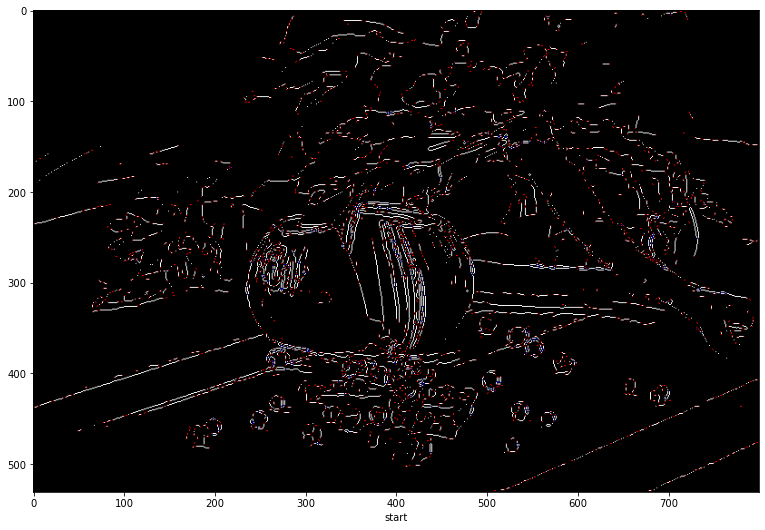

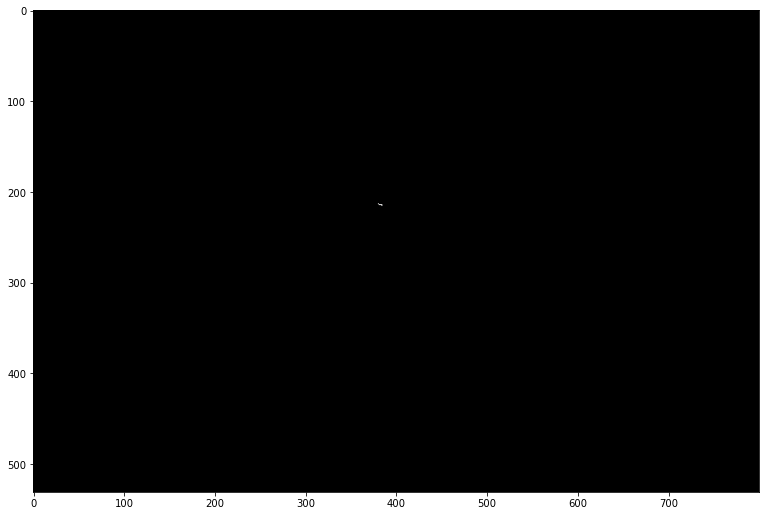

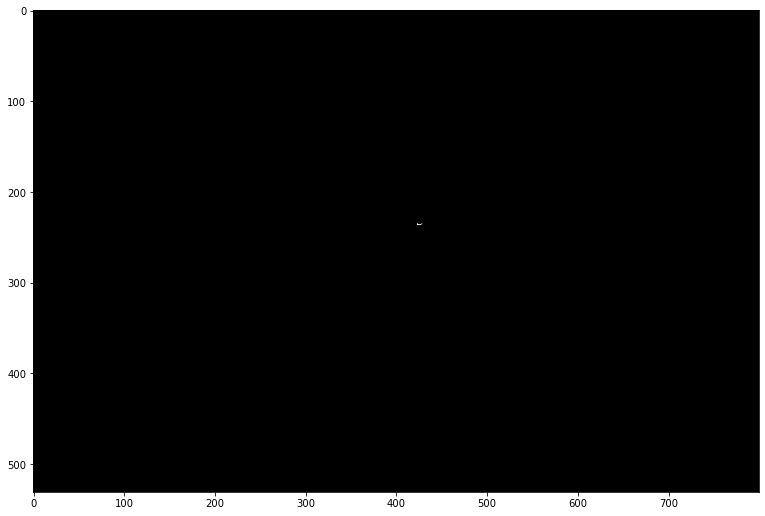

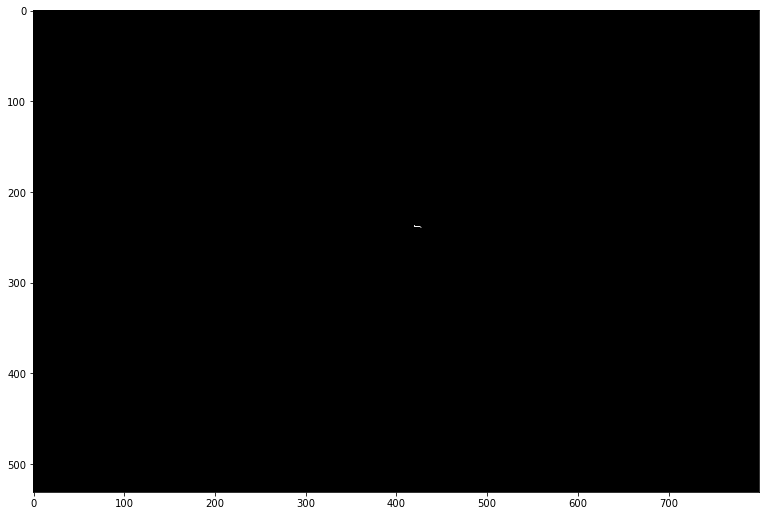

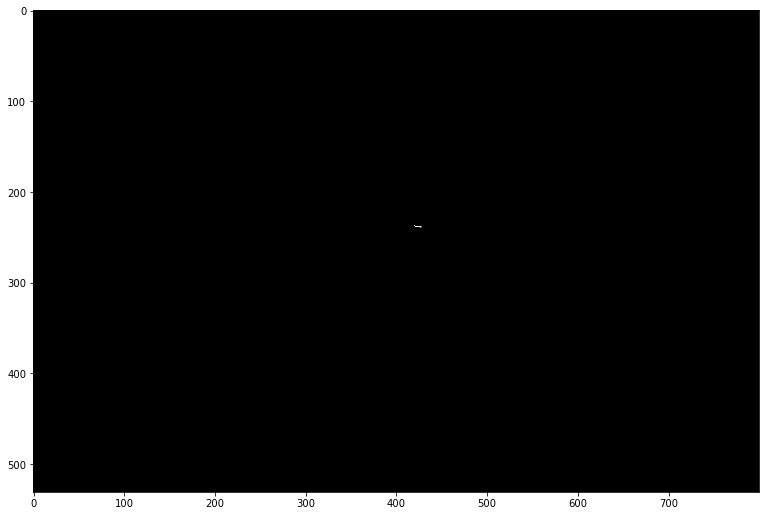

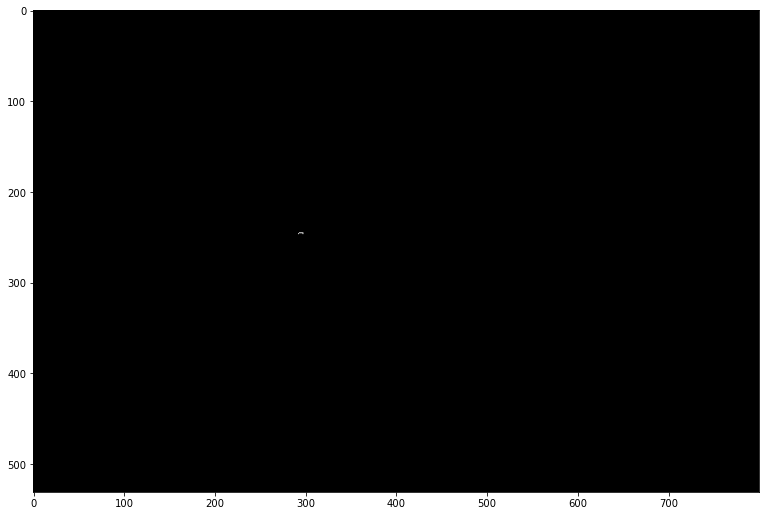

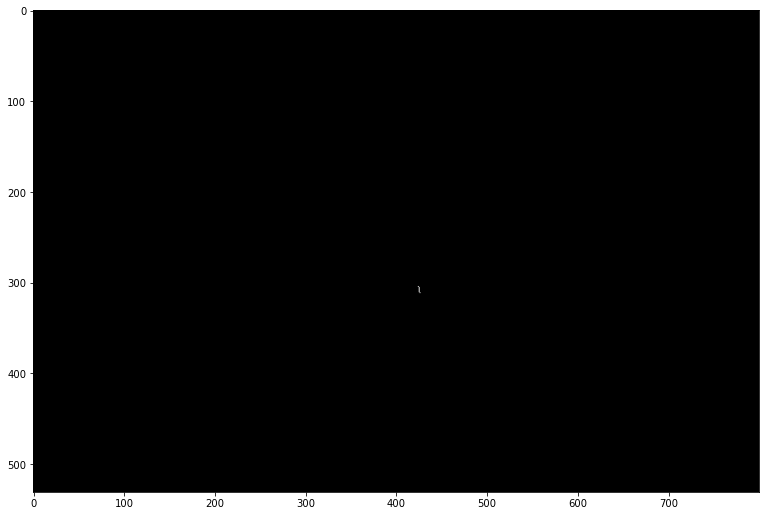

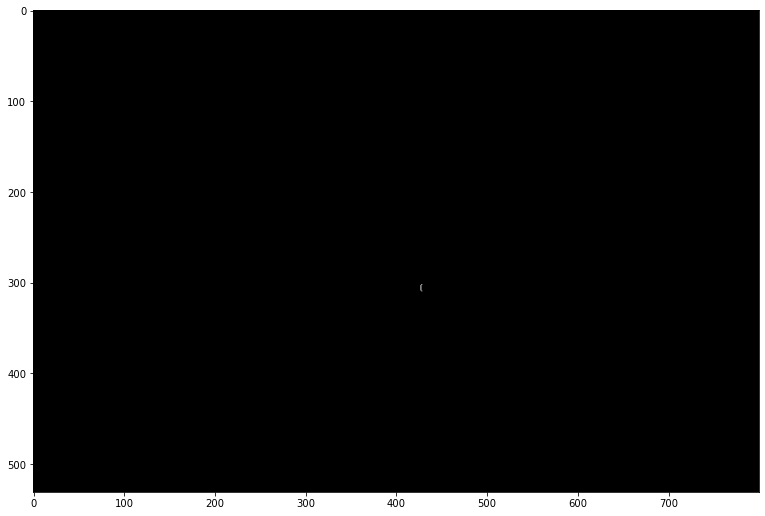

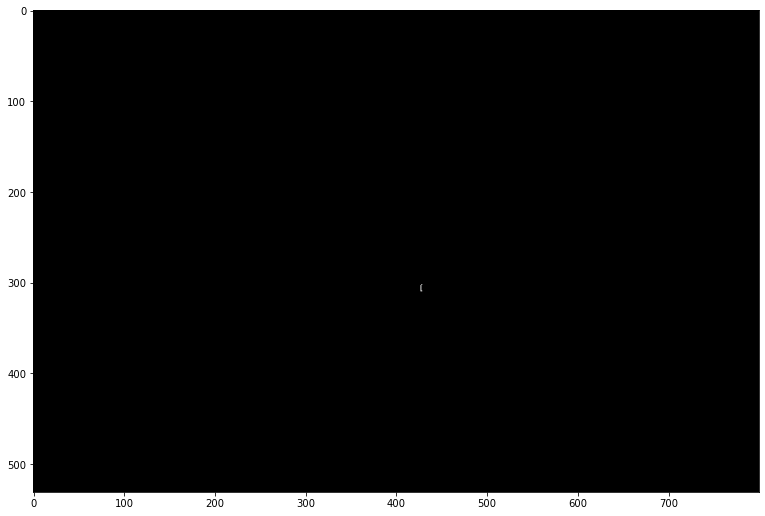

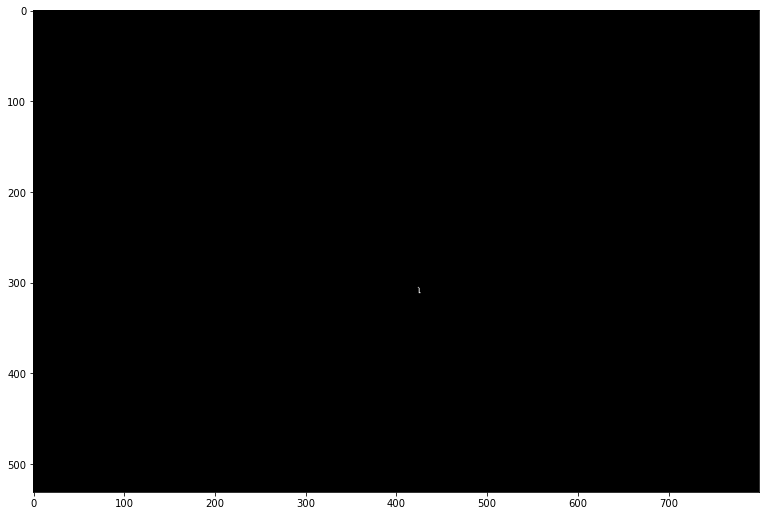

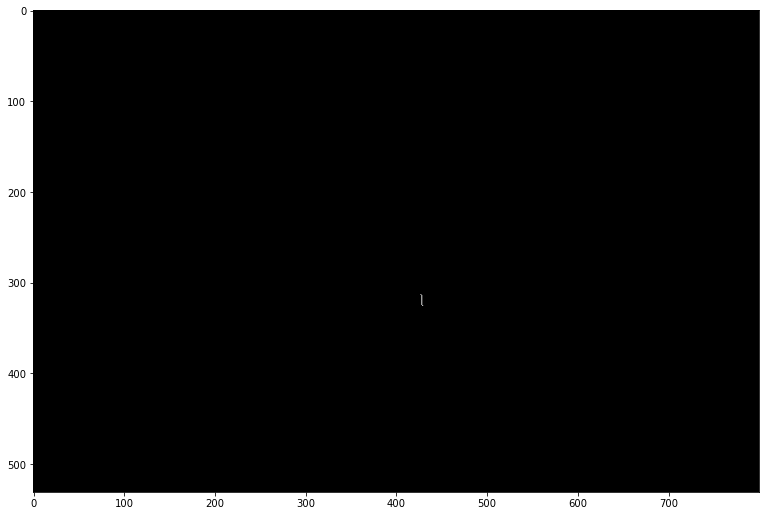

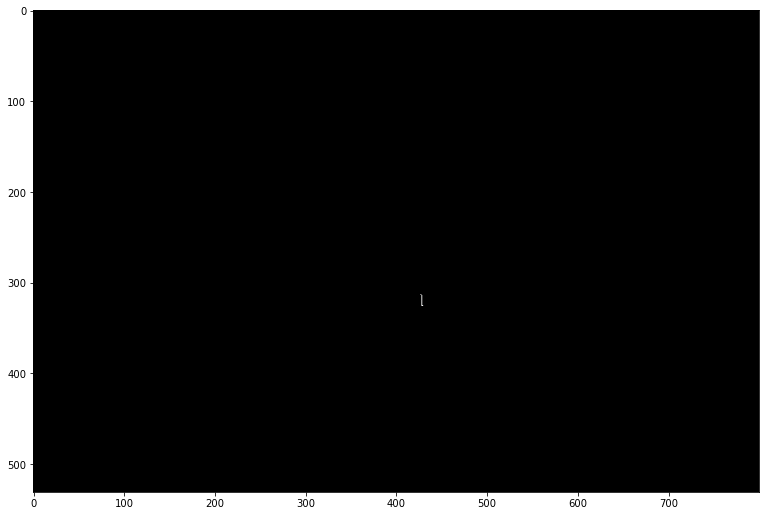

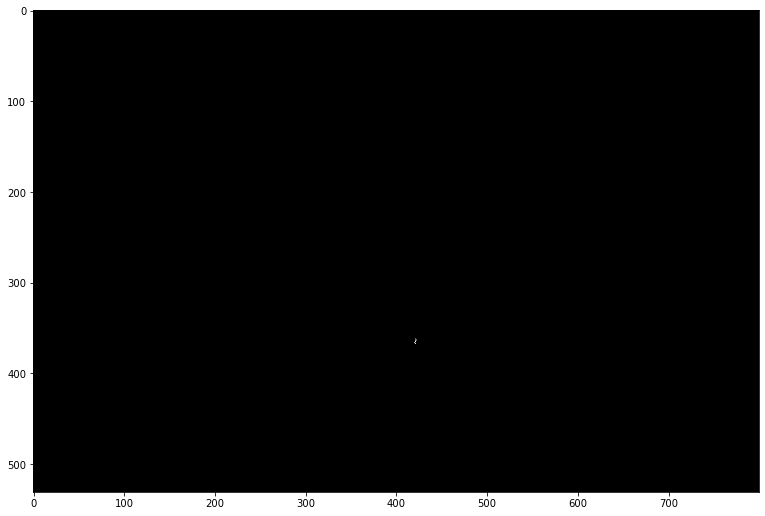

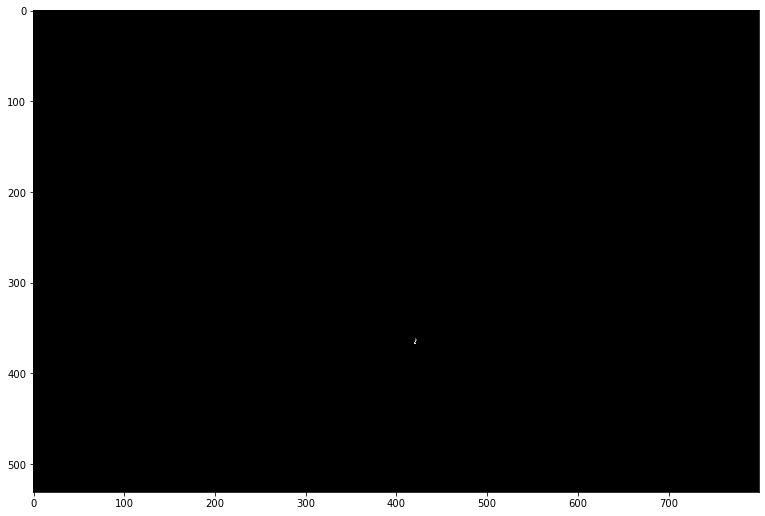

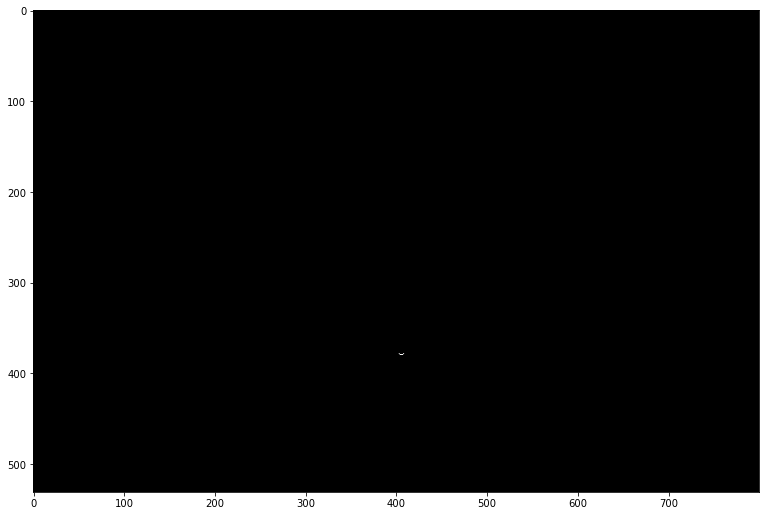

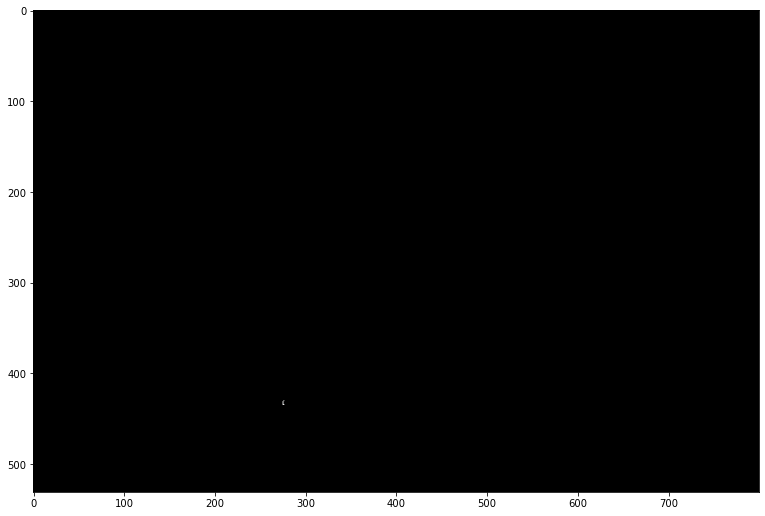

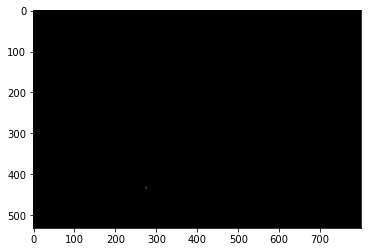

In [8]:
plt.figure(figsize=(13,13))
spta_img = SPTA(canny_img)

small = spta_img
segmented = edge_segment_detection(small)

edge = np.zeros([small.shape[0],small.shape[1]],np.uint8)
for s in segmented:
    if len(s)>5:
        edge = np.zeros([small.shape[0],small.shape[1]],np.uint8)
        fig = plt.figure(figsize=(13,13))
        for i in s:
            y,x = i
            edge[y,x]=255
        plt.imshow(edge,cmap='gray')
        plt.show()

